In [1]:
# Copyright 2023 NVIDIA Corporation. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# Basic graph generation demo (lastfm)

This notebook demonstrates an example of mimicking a no-partite graph structure by providing an edge list of the target graph directly to the graph generator, responsible for generating the structure. In this example the target graph will be the one from the [lastfm](https://snap.stanford.edu/data/feather-lastfm-social.html) dataset. 

### Content

1. [Preprocessing (graph loading)](#1)
1. [Fitting graph generator](#2)
1. [Graph generation](#3)
1. [Result analysis](#4)

In [1]:
import math
import numpy as np
from syngen.generator.graph import RMATGenerator, RandomGraph

from syngen.analyzer.graph import Graph
from syngen.analyzer.graph.analyser import AnalysisModule
from syngen.analyzer.graph.stats import get_dd_simmilarity_score

<a id="1"></a>
### Load graph

We are interesting only in the structural part of the [lastfm](https://snap.stanford.edu/data/feather-lastfm-social.html) dataset, so we load exclusively the edges.

In [2]:
# read only graph structure data
graph_orig = np.loadtxt('/workspace/data/lasftm_asia/lastfm_asia_edges.csv', delimiter=',', skiprows=1, dtype=np.int32)

# extract graph info
num_edges = len(graph_orig)
num_nodes = np.max(graph_orig) - np.min(graph_orig) + 1
num_edges, num_nodes

(27806, 7624)

<a id="2"></a>
### Fit generator to graph

Now that we have loaded the graph structure, the `RMATGenerator`, which is one of the graph generators implemented, is instantiated and fitted on this graph.

In [3]:
static_graph_generator = RMATGenerator()
static_graph_generator.fit(graph_orig)

In [4]:
print("FIT RESULTS", static_graph_generator.get_fit_results())

FIT RESULTS (0.4978122711181645, 0.17209129333496098, 0.15978355407714862, 0.1703128814697259)


<a id="3"></a>
### Generate graphs

The fitted generator can be used to generate graphs of arbitrary size.
A few examples are provided below

In [ ]:
graph_proper = static_graph_generator.generate(num_nodes=num_nodes, 
                                                  num_edges=num_edges, 
                                                  is_directed=False, 
                                                  has_self_loop=False, 
                                                  noise=0.5)

In [6]:
graph_proper_10x = static_graph_generator.generate(num_nodes=num_nodes*math.sqrt(10), 
                                                      num_edges=num_edges*10, 
                                                      is_directed=False, 
                                                      has_self_loop=False, 
                                                      noise=0.5)

In [7]:
random_graph_generator = RandomGraph(seed=42)
graph_random = random_graph_generator.generate(num_nodes=num_nodes, 
                                               num_edges=num_edges, 
                                               is_directed=False, 
                                               has_self_loop=False,
                                               noise=0.0)

In [8]:
graph_random_10x = random_graph_generator.generate(num_nodes=num_nodes*math.sqrt(10), 
                                                   num_edges=num_edges*10, 
                                                   is_directed=False, 
                                                   has_self_loop=False, 
                                                   noise=0.0)

### Convert graph to SNAP

Next the original graph is converted to [SNAP](https://snap.stanford.edu/), where the graph analyzer is used to analyze the generated graphs against the original.

In [9]:
np.savetxt('/workspace/data/lastfm_demo_orig.txt', graph_orig, fmt='%i', delimiter='\t')
np.savetxt('/workspace/data/lastfm_demo_proper.txt', graph_proper, fmt='%i', delimiter='\t')
np.savetxt('/workspace/data/lastfm_demo_random.txt', graph_random, fmt='%i', delimiter='\t')
np.savetxt('/workspace/data/lastfm_demo_proper_10.txt', graph_proper_10x, fmt='%i', delimiter='\t')
np.savetxt('/workspace/data/lastfm_demo_random_10.txt', graph_random_10x, fmt='%i', delimiter='\t')

In [10]:
proper_graph = Graph('/workspace/data/lastfm_demo_proper.txt', name='properly_generated', load_eagerly=True, is_directed=False)
random_graph = Graph('/workspace/data/lastfm_demo_random.txt', name='randomly_generated', load_eagerly=True, is_directed=False)
proper_graph_10x = Graph('/workspace/data/lastfm_demo_proper_10.txt', name='properly_generated_10', load_eagerly=True, is_directed=False)
random_graph_10x = Graph('/workspace/data/lastfm_demo_random_10.txt', name='randomly_generated_10', load_eagerly=True, is_directed=False)

orig_graph = Graph('/workspace/data/lastfm_demo_orig.txt', name='original', load_eagerly=True, is_directed=False)
all_graphs = [proper_graph, random_graph, orig_graph, proper_graph_10x, random_graph_10x]

<a id="4"></a>
### Result analysis

In [11]:
orig_proper = get_dd_simmilarity_score(graph_orig, graph_proper, cdf_points=1000)
orig_random = get_dd_simmilarity_score(graph_orig, graph_random, cdf_points=1000)

print("DEGREE SIMILLARITY SCORE")
print("ORIG vs PROPER:", orig_proper)
print("ORIG vs RANDOM:", orig_random)

DEGREE SIMILLARITY SCORE
ORIG vs PROPER: 0.9667267895362643
ORIG vs RANDOM: 0.4424067282769476


In [12]:
graph_analyser = AnalysisModule()
df = graph_analyser.compare_graph_stats(*all_graphs)
df

,Category,Statistic,properly_generated,randomly_generated,original,properly_generated_10,randomly_generated_10
0,Global stats,Nodes,5800,8169,7624,29963,32768
1,Global stats,Edges,27806,27806,27806,278060,278060
2,Global stats,Density,0.0017,0.0008,0.001,0.0006,0.0005
3,Global stats,Average degree,4.79,3.4,3.65,9.28,8.49
4,Global stats,Zero deg nodes,0,0,0,0,0
5,Global stats,Zero in deg nodes,0,0,0,0,0
6,Global stats,Zero out deg nodes,0,0,0,0,0
7,Global stats,Self loops,0,0,0,0,0
8,Global stats,Bidirectional edges,27806,27806,27806,278060,278060
9,Global stats,Unique undirected edges,27806,27806,27806,278060,278060


The degree distribution comparison and hop plots can also be visualized by calling the `compare_graph_plots` fn on the analyzer.

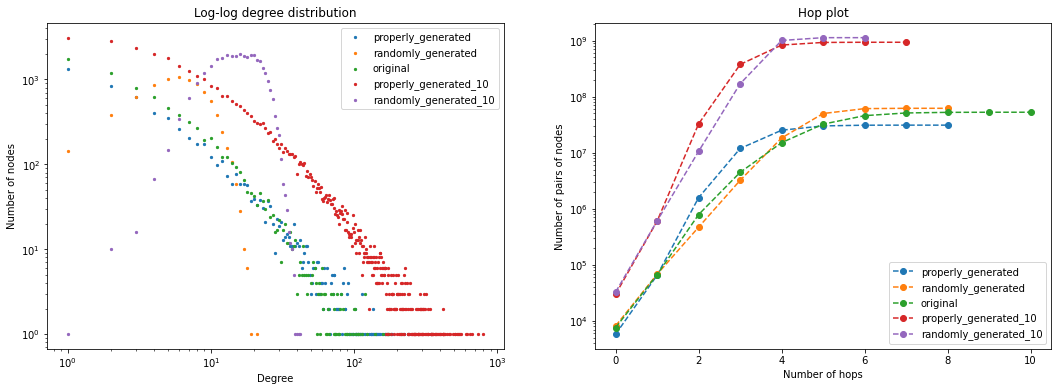

In [13]:
_ = graph_analyser.compare_graph_plots(*all_graphs)